<a href="https://colab.research.google.com/github/mayuresh23sawant/DeepLearning/blob/master/Food_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **FOOD-101**

# Imports and Data Preprocessing

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install utils
!pip install fastai2

from utils import *
from fastai2.vision.all import *

In [0]:
path = untar_data(URLs.FOOD)

In the cell below, I split the dataset into training and validation data according the the metadata.

In [0]:
# Helper method to split dataset into train and test folders
from shutil import copy
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
print("Creating train data...")
prepare_data(path/'train.txt', path/'images', path/'train')

# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
print("Creating test data...")
prepare_data(path/'test.txt', path/'images', path/'test')

Creating train data...
Copying Done!
Creating test data...
Copying Done!


# Data Prep and Augmentation

### Dataloaders
DataLoaders is a thin class in Fastai that just stores whatever DataLoader objects we pass to it, and makes them available as train and valid DataLoader objects. 

To crete a DataLoader we use something called the data block API. With this API  we can customize every stage of the creation of DataLoaders. 

To create a DataLoader, we need to specify four things:
*   The type of data --> Images(independen variable) and Categories(dependent variable)
*   How to get the data --> Take the "path" and recursively get the items.
*  How to split the data --> From the name of grandparent folder(test or train)
*  How to get the labels --> From the parent folder of the images
* Item Transforms --> To make a batch, all images must be of the same size, hence the resize to 224
* Batch Transforms --> Apply a set of transformations (Augmentation and Normalization) on a mini batch of images. 



In [0]:
def get_dls(bs, size):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   splitter = GrandparentSplitter(valid_name='test',train_name='train'),
                   item_tfms=Resize(224),
                   batch_tfms=[*aug_transforms(mult=1.0, size=size,min_scale=1.0),
                               Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(path, bs=bs)

### But what is Data Augmentation and Normalization 🤔

#### Data  Augmentation:
Data Augmentation refers to create random variations of the input data. This helps us increase the diversity of the data without actually adding more data. Fastai's optimal data augmentations incude flipping, warping, rotaation, zooming and brightness & contrast alterations. Apart from these standard augmentations, a new range of power techniques have been developed in recent years. [Cutout](https://arxiv.org/abs/2004.14990), [MixUp](https://arxiv.org/abs/1710.09412), [CutMix](https://arxiv.org/abs/1905.04899), [Attentive CutMix](https://arxiv.org/abs/2003.13048), and [Ricap](https://arxiv.org/abs/1811.09030).

All these techniques have shown significant improvement compared the the baseline results. In my approach, tried both MixUp and CutMix, and found CutMix to be slightly better. 

#### Normalization:
When using a pretained model like ResNet50, it only knows how to work with data of the type that it has seen before. If the average pixel value was 0 in the data it was trained with, but our data has 0 as the minimum possible value of a pixel, then the model is going to be very confused. Hence it helps if we normalize our data to get a mean of 0 and standard deviation of 1.

In [0]:
dls = get_dls(128, 128)

In the above cell, I made adataloader with a batch size of 128 and images of size 128\*128. Why have I reduced the size of the image? 

Because of progressive resizing. You can [read](https://www.theverge.com/2018/5/7/17316010/fast-ai-speed-test-stanford-dawnbench-google-intel) how Fastai beat even Google and Intel by using this simple technique. I start with size 128\*128 and then go on till 512\*512 in the later epochs. 

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


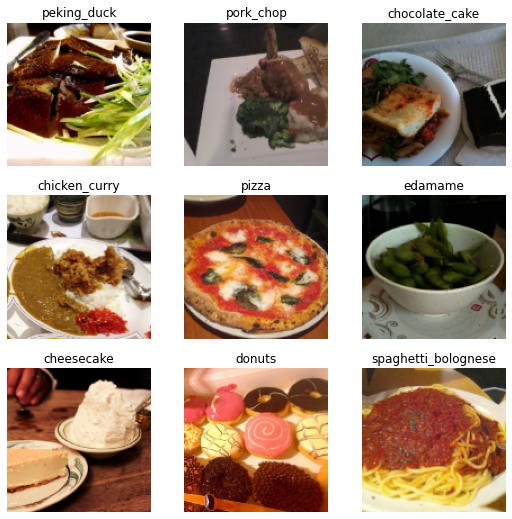

In [0]:
# Lets see how our data looks like 
dls.show_batch(nrows=3,ncols=3)

In [0]:
from fastai2.callback.cutmix import *

### Creating a Learner

In this cell, I create a convolutional neural network and I will specify:
* What data to use --> Our already created DataLoader
* What architecture to use --> A pretrained ResNet50 (Using Transfer Learning)
* Which Loss Function to use --> [Label Smoothing Cross Entropy](https://arxiv.org/abs/1512.00567)
* Metrics --> Top 1 accuracy and Top k (default=5) accuracy
* Callbacks --> Builtin fastai callback to implement CutMix data augmentation

In [0]:
cutmix = CutMix(1.)
learn = cnn_learner(dls, resnet50, loss_func=LabelSmoothingCrossEntropy(), 
                metrics=[accuracy,top_k_accuracy],
                cbs=cutmix)

# Training Stage 1

Let us first plot the learning rate plot of ResNet50. Fastai provides a simple function to use the [learning rate finder](https://arxiv.org/abs/1506.01186). The plot starts with a very small learning rate and keeps on doubling it till a point the loss starts getting worse instead of better. This is made into a learning rate vs. loss graph which is easily interpretable.  

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


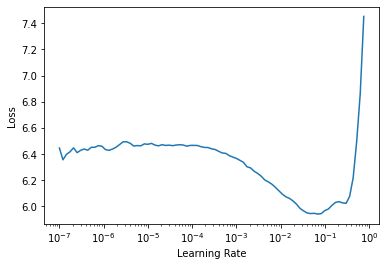

In [0]:
_,lr_steep = learn.lr_find()

We select a learning rate from which the loss will continually decrease and then fine tune our model. 
ResNet50 has already been trained on the ImageNet dataset which contains more than a million data points. It already understands how to detect objects and colors. Hence, we dont have to change those weights and biases significantly. Fine_tune helps us do exactly that. 

In [0]:
learn.fine_tune(5,lr_steep)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,4.009070,2.880032,0.393307,0.674218,19:32


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,3.257097,2.332124,0.543327,0.810574,19:47
1,2.799357,2.017897,0.637822,0.873980,19:26
2,2.603895,1.851791,0.686099,0.899010,19:21
3,2.371871,1.746205,0.717782,0.914416,19:39
4,2.253657,1.716966,0.725624,0.918059,19:27


72% accuracy at the end of 5 epochs is not bad. Remember the first classifier on this dataset only had an accuracy of 54%. 

In [0]:
learn.save('res50_1')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


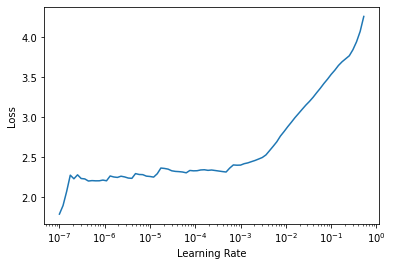

In [0]:
learn.unfreeze()
_,lr_steep = learn.lr_find()

# Training Stage 2

Here, I will increase the size of images to 248/*248 and reduce my batch size in half so that I don't consume all the GPU resources. 

In [0]:
learn.dls=get_dls(64,248)

In [0]:
learn.fit_one_cycle(5,lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.193065,1.551230,0.788356,0.948950,39:52
1,2.035844,1.494897,0.804238,0.956396,39:41
2,2.034773,1.468446,0.812634,0.957703,39:44
3,1.979540,1.457546,0.815208,0.959366,39:41
4,1.961517,1.447055,0.818891,0.959881,39:45


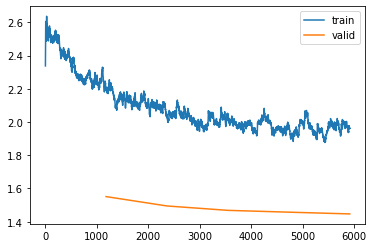

In [0]:
learn.recorder.plot_loss()

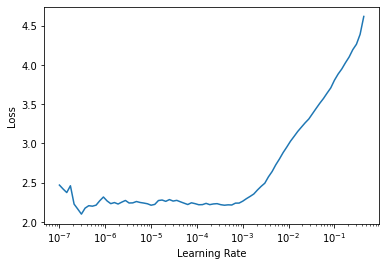

In [0]:
_,lr_steep = learn.lr_find()

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
learn=load_learner('/content/gdrive/My Drive/export.pkl')

# Training Stage 3

In [0]:
learn.unfreeze()

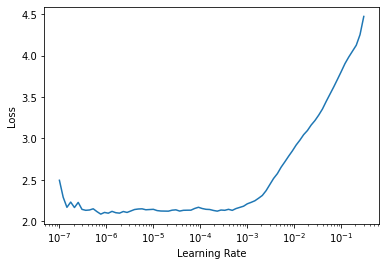

In [0]:
learn.dls=get_dls(32,512)
_,lr_steep = learn.lr_find()

In [0]:
learn.fit_one_cycle(5,slice(1e-5,3e-4))
learn.export('/content/drive/My Drive/food-101/export3.pkl')

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.938152,1.498286,0.809069,0.957663,35:55
1,1.823871,1.405964,0.837465,0.967564,35:49
2,1.653499,1.302037,0.863683,0.975564,35:53
3,1.509039,1.240161,0.882614,0.979683,35:54
4,1.418659,1.223458,0.888277,0.980832,35:52


FileNotFoundError: ignored



> Kindly ignore the error above, it was just because of passing a wrong directory. 



In [0]:
learn.export('/content/gdrive/My Drive/food-101/export3.pkl')

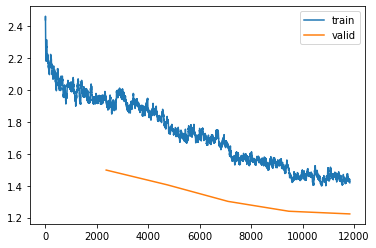

In [0]:
learn.recorder.plot_loss()

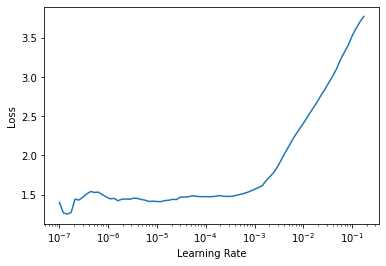

In [0]:
learn.unfreeze()
learn.dls=get_dls(32,512)
_,lr_steep = learn.lr_find()

# Inference

### Test Time Augmentations

During inference or validation, it creates multiple versions of each image, using data augmentation, and then takes the average (or maximum) of the predictions for each augmented version of the image. This gives a slight boost to the accuracy. 

In [0]:
preds,targs = learn.tta()
print("Top 1 Accuracy: {}\nTop 5 Accuracy: {}".format(accuracy(preds, targs).item(),top_k_accuracy(preds, targs).item()))

Top 1 Accuracy: 0.8932276964187622
Top 5 Accuracy: 0.9816633462905884


# Training Stage 4 (Optional)

In [0]:
learn=load_learner('/content/drive/My Drive/food-101/export3.pkl')

In [0]:
dls=get_dls(32,512)

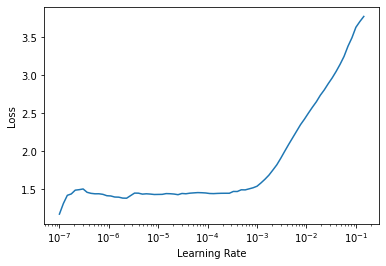

In [0]:
learn.unfreeze()
learn.dls=get_dls(32,512)
_,lr_steep = learn.lr_find()

In [0]:
learn.fit_one_cycle(5,slice(4e-7,3e-6))
learn.export('/content/drive/My Drive/food-101/export4.pkl')

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.425377,1.223671,0.889109,0.980752,36:16
1,1.455666,1.221559,0.889426,0.980238,36:13
2,1.414112,1.218307,0.890099,0.981109,36:08
3,1.401903,1.217601,0.889228,0.980594,36:07
4,1.437707,1.218796,0.890059,0.981465,36:09


As it can be seen, the trainig and validation loss have started increasing and this is a sign that the model is beginning to overfit. Hence, we will discard this part and use the model from stage 3. 

# Production

We can also make a full fledged web or mobile app but as of now, this works perfectly fine. Just download the model and run the code below in a notebook!

In [0]:
from fastai2.vision.widgets import *

path = Path()
#learn_inf = load_learner('/content/gdrive/My Drive/food-101/export3.pkl')
learn_inf=learn
btn_upload = widgets.FileUpload()
out_pl = widgets.Output()
lbl_pred = widgets.Label()

In [0]:
def on_click(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

In [0]:
btn_upload.observe(on_click, names=['data'])

In [0]:
display(VBox([widgets.Label('Upload a food item!'), btn_upload, out_pl, lbl_pred]))

# Acknowledgement

If anyone wants to learn about deep learning and doesn't know where to start? I can't recommend [fast.ai](fast.ai) enough. Fast.ai team has made a wonderful library in fastai which has made Deep Learning very easy to implement. Also the top down approach of Jeremy Howard will teach you how to do things before explaining how they really work. 

Seriously, the best deep learning resource I have found. 